In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-29 15:22:30.744888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 15:22:37.079038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/test_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [ ]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [3]:
g_train = nx.read_graphml("./graph/train_graph.gml")

In [4]:
g = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [5]:
#g = nx.create_empty_copy(g)
G = StellarGraph.from_networkx(g_merged,
                               node_features={'species': species_features_dummy,
                                              'molecule':molecule_features_dummy})

In [6]:
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 700916

 Node types:
  molecule: [148190]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 70
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none


In [7]:
model = tf.keras.models.load_model("./model/batch_128_layer_256", compile=True)

In [9]:
test = df_agg[['structure_smiles_2D', 'organism_name']].to_numpy()

In [ ]:
#test = test[['structure_smiles_2D', 'organism_name']].to_numpy()

In [27]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=256,
                                num_samples=[2,1],
                                head_node_types=["molecule", "species"]).flow(test, np.ones(len(test)).reshape(-1, 1))

In [51]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [50]:
result = predict(model, test_flow)

343/343 [==============================] - 6s 19ms/step


In [43]:
sum(result>0.9)/len(result)

0.4234711347501541

(array([  504.,   598.,   853.,  1408.,  2279.,  4147.,  7110., 12091.,
        20864., 37760.]),
 array([5.88739291e-04, 1.00403905e-01, 2.00219065e-01, 3.00034225e-01,
        3.99849385e-01, 4.99664545e-01, 5.99479735e-01, 6.99294865e-01,
        7.99110055e-01, 8.98925185e-01, 9.98740375e-01]),
 <BarContainer object of 10 artists>)

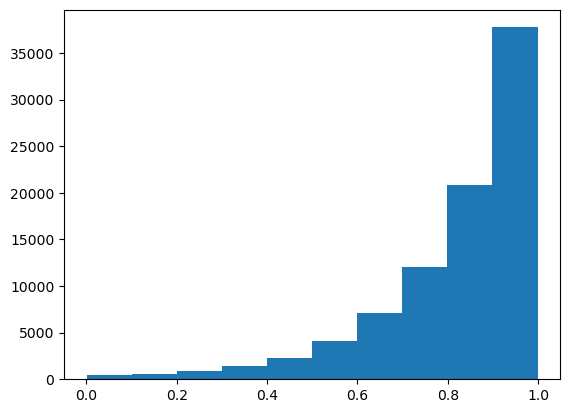

In [47]:
plt.hist(result)

In [52]:
sum(result>0.5)/len(result)

0.9350103864679161

In [37]:
res_single_run = model.predict(test_flow).flatten()

343/343 [==============================] - 8s 23ms/step


In [39]:
sum(res_single_run>0.5)/len(res_single_run)

0.8914442897253864

In [19]:
try_test = np.array([['C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12', 'Homo sapiens']])

In [20]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=256,
                                num_samples=[2,1],
                                head_node_types=["molecule", "species"]).flow(try_test, np.ones(len(try_test)).reshape(-1, 1))

In [21]:
ls = []
it = 20
for _ in range(it):
    ls.append(model.predict(test_flow).flatten())

ls = np.mean(ls, axis=0)

1/1 [==============================] - 0s 35ms/step


In [22]:
ls

array([0.8482809], dtype=float32)